In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import metrics

In [2]:
df = pd.read_csv('../Mid_lane.csv')
lane = df.drop(columns = ['Lane', 'Unnamed: 0', 'Summoner', 'Item_0', 'Item_1', 'Item_2', 'Item_3', 'Item_4', 'Item_5', 'Item_6'])

In [3]:
lane.head()

,Champion,Kills,Deaths,Assists,Killing_Spree,Multikills,Total_Damage,Damage_To_Objectives,Damage_To_Turrets,Damage_Taken,Gold_Earned,Champ_Level,Wards_Bought,Vision_Score,Crowd_Controls,champion_name
0,518,3,6,4,2,1,16640,19544,6147,18458,11011,15,0,18,25,Neeko
1,13,4,3,8,2,2,13014,7945,1234,11345,9202,13,2,15,12,Ryze
2,268,7,6,7,2,1,27212,5089,4542,18927,13468,15,3,22,12,Azir
3,42,4,6,3,3,2,21081,4272,1272,20363,11497,15,4,25,0,Corki
4,136,3,2,2,2,1,5804,0,0,11131,7530,11,2,7,10,AurelionSol


# Lots of champions can be played in any lane due to one trick players getting auto-filled. So to make sure my clustering is built on sufficient data, I am filtering out champions who are played less than 5 times in this role.

In [4]:
for champ in list(lane.groupby('Champion').count().query("Kills < 5").index):
    lane = lane[lane['Champion'] != champ]                           

In [5]:
lane = lane.groupby("Champion").mean()

In [6]:
lane.head()

,Kills,Deaths,Assists,Killing_Spree,Multikills,Total_Damage,Damage_To_Objectives,Damage_To_Turrets,Damage_Taken,Gold_Earned,Champ_Level,Wards_Bought,Vision_Score,Crowd_Controls
Champion,,,,,,,,,,,,,,
1,4.858859,4.726727,6.303303,2.519520,1.264264,14522.357357,3952.075075,2140.381381,14431.432432,9545.891892,13.231231,1.963964,18.912913,20.411411
4,4.201077,4.459605,6.916517,2.267504,1.188510,13460.886894,6496.599641,3732.578995,16448.592460,10803.631957,13.654399,2.560144,19.842011,27.775583
7,5.852725,4.388807,5.770250,3.142857,1.331370,15769.424153,3172.354934,1952.721649,17713.874816,9774.512518,13.581738,2.764359,20.078056,13.893962
13,4.505563,5.170376,5.233658,2.248261,1.280946,16337.280946,7805.739221,2665.260779,18139.865786,10368.472184,13.897775,3.004868,19.440890,19.062587
34,4.604651,4.186047,6.380814,2.706395,1.258721,14895.151163,5534.712209,2287.375000,20330.709302,10381.880814,13.976744,2.174419,17.927326,34.177326


# To determine the optimal amount of clusters, I am going to run a loop of various K values and plot the errors to pick the ideal number of clusters based on where the "elbow" is.

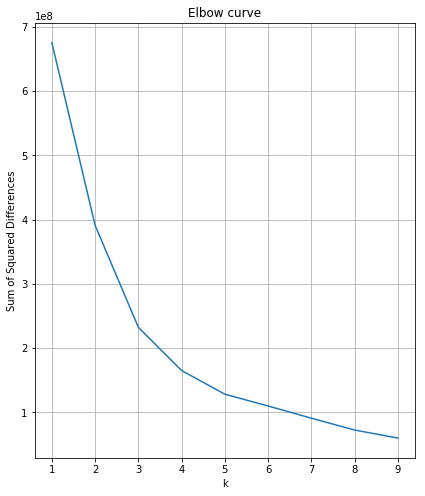

In [8]:
distorsions = []

for k in range(1,10):
    kmeans = KMeans(n_clusters=k, random_state = 301)
    kmeans.fit(lane)
    distorsions.append(kmeans.inertia_)

# Plot values of SSE
plt.figure(figsize=(15,8))
plt.subplot(121, title='Elbow curve')
plt.xlabel('k')
plt.ylabel('Sum of Squared Differences')
plt.plot(range(1, 10), distorsions)
plt.grid(True)

There is no clear "elbow" here to easily determine the ideal number of clustes. As such, I am going to use the silhouette plot to determine the ideal number of clusters based on this data.

In [9]:
silhouette_plot = []
for k in range(2, 10):
    clusters = KMeans(n_clusters=k, random_state=10)
    cluster_labels = clusters.fit_predict(lane)
    silhouette_avg = metrics.silhouette_score(lane, cluster_labels)
    silhouette_plot.append(silhouette_avg)

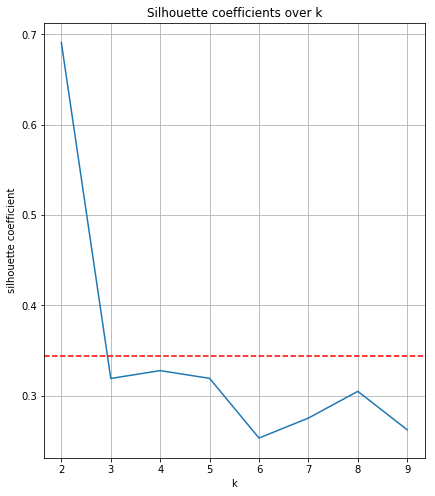

In [10]:
plt.figure(figsize=(15,8))
plt.subplot(121, title='Silhouette coefficients over k')
plt.xlabel('k')
plt.ylabel('silhouette coefficient')
plt.plot(range(2, 10), silhouette_plot)
plt.axhline(y=np.mean(silhouette_plot), color="red", linestyle="--")
plt.grid(True)

The highest point, which also happens to be the second "elbow" is at 6 clusters and so I will use that to further analyze the playstyles in the bot lane.

In [39]:
k_means = KMeans(n_clusters = 3).fit(lane.groupby('Champion').mean())
cluster_assignments = k_means.predict(lane.groupby('Champion').mean())

In [40]:
cluster_assignments

array([0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0,
       1, 0, 1, 1, 1, 1, 0, 0], dtype=int32)

In [41]:
clustered = lane.groupby('Champion').mean()

In [42]:
clustered['Cluster'] = cluster_assignments

In [43]:
clustered.groupby("Cluster").count()['Kills']

Cluster
0    15
1    14
2     1
Name: Kills, dtype: int64

There are 5 champions in Cluster 0, 4 champions in cluster 1, 6 champions in cluster 2, and ONLY 1 champion in cluster 3. 

In [44]:
clustered.groupby("Cluster").mean()

,Kills,Deaths,Assists,Killing_Spree,Multikills,Total_Damage,Damage_To_Objectives,Damage_To_Turrets,Damage_Taken,Gold_Earned,Champ_Level,Wards_Bought,Vision_Score,Crowd_Controls
Cluster,,,,,,,,,,,,,,
0,4.888993,4.683572,6.497375,2.538192,1.284345,15860.046938,5380.514666,2823.953052,14839.835639,10109.710854,13.628879,2.405024,19.984450,23.142200
1,6.047561,4.996427,5.571773,3.062018,1.450377,16479.624975,5672.347470,2470.206830,19439.913343,10524.630092,13.806635,2.311682,19.138904,13.921744
2,4.281609,4.252874,6.557471,2.183908,1.275862,19272.942529,16947.885057,14312.568966,12837.316092,10483.614943,13.660920,2.706897,19.488506,14.574713


# Based on the average values of the clusters above, it looks like the one champion in Cluster 2 had an outlier performance where the values are drastically different from every other cluster.

In [45]:
champion_names = 'http://ddragon.leagueoflegends.com/cdn/9.13.1/data/en_US/champion.json?fbclid=IwAR3wpqEjCmWqLKToVoMwWz-iGVCkHaVVfVOWtvy9OpfKrM7Hjt1YZ4VyPk8'

df = pd.read_json(champion_names)

champs = []
ids = []
for names in list(df['data']):
    champs.append(names['id'])
    ids.append(names['key'])

champ_dict = {}

for champ in range(len(champs)):
    champ_dict[ids[champ]] = champs[champ]

clustered['champion_name'] = clustered.index.map(lambda x: champ_dict[str(x)] )



In [51]:
clustered[clustered['Cluster'] == 2]

,Kills,Deaths,Assists,Killing_Spree,Multikills,Total_Damage,Damage_To_Objectives,Damage_To_Turrets,Damage_Taken,Gold_Earned,Champ_Level,Wards_Bought,Vision_Score,Crowd_Controls,Cluster,champion_name
Champion,,,,,,,,,,,,,,,,
115,4.281609,4.252874,6.557471,2.183908,1.275862,19272.942529,16947.885057,14312.568966,12837.316092,10483.614943,13.66092,2.706897,19.488506,14.574713,2,Ziggs


# 

In [32]:
clustered.groupby('Cluster').mean()

,Kills,Deaths,Assists,Killing_Spree,Multikills,Total_Damage,Damage_To_Objectives,Damage_To_Turrets,Damage_Taken,Gold_Earned,Champ_Level,Wards_Bought,Vision_Score,Crowd_Controls
Cluster,,,,,,,,,,,,,,
0,5.283138,4.860222,5.600889,2.689736,1.380212,16142.012885,8132.500330,3625.936042,16925.909478,10802.812399,13.830666,2.343791,19.003157,13.935818
1,4.782674,4.708111,6.682190,2.487483,1.269240,15870.502129,4678.620304,2495.720506,14557.294058,9936.715852,13.587317,2.448424,20.260515,25.175883
2,4.281609,4.252874,6.557471,2.183908,1.275862,19272.942529,16947.885057,14312.568966,12837.316092,10483.614943,13.660920,2.706897,19.488506,14.574713
3,6.264530,4.958627,5.606712,3.177540,1.459845,16483.395534,5016.558085,2294.357188,19864.848711,10448.456316,13.790388,2.272280,19.142389,14.210174
